In [16]:
import pandas as pd
import numpy as np
import spacy
import gensim
from collections import Counter 
import sklearn.cluster
import random
from sklearn.model_selection import KFold

random.seed(0)

In [2]:
# data import
data = pd.read_excel(r'../data/Datos Codificados Estudio v2a.xlsx')
model = gensim.models.KeyedVectors.load_word2vec_format( 
    r'../Data/SBW-vectors-300-min5.bin.gz', # using the spanish billion words embeddings
    binary=True # the model is in binary format
)

In [3]:
nlp = spacy.load('es_core_news_sm')

In [4]:
df = data[["Palabra (concepto)", "Descripción", "Codificación"]].copy()

In [5]:
def clean_text(text):
    """
    Recive a string and return the string in tokens without punctuations
    and in lowercase
    """
    # for each token in the sentence add to the list if is not a punctuation
    return [t for t in nlp(text.lower()) if not t.is_punct]
    
def normalize(tokens):
    """
    Recive al list of string and return in one string without stop words
    """
    # for each token if is not a stop word add the word to the list
    words = [t.orth_ for t in tokens if not t.is_stop]

    # return the tokens in one string
    return(" ".join(words))

In [6]:
# Normalizacion de los conceptos, descripciones y codificaciones
for i in range(len(data)):
    df['Descripción'][i] = normalize(clean_text(df['Descripción'][i]))

In [7]:
df['Descripción'].head(5)

0                         sentimiento
1    perdona vida a alguien peliculas
2         necesario cumplir objetivos
3       organizar recursos o personas
4                          estrategia
Name: Descripción, dtype: object

In [8]:
# TODO: LSA 
# ? La impletemtación es a todo el dataset o solo a las palabras del train dataset

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer


contador = CountVectorizer()
tf = contador.fit_transform(df['Descripción'])
transf = TfidfTransformer()
tfidf = transf.fit_transform(tf)

In [9]:
tfidf[0]
# contador.get_feature_names_out()

<1x3323 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>

In [10]:
from sklearn.decomposition import TruncatedSVD
import seaborn as sns

# Igualando los numeros de dimensiones con el Word2Vec
numDim = 1296 # es el numero de codificaciones existentes
# numDim = 33 # numero de conceptos
vocab = contador.get_feature_names_out()

lsa = TruncatedSVD(n_components=numDim, n_iter=100, random_state=42)
# U, Sigma, VT = np.linalg.svd(tfidf.toarray())
tfidf_lsa_data = lsa.fit_transform(tfidf)

# sns.barplot(x=list(range(len(Sigma))), y = Sigma)

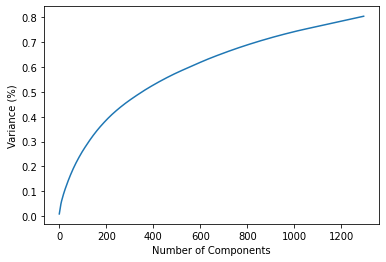

In [11]:
import matplotlib.pyplot as plt
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(lsa.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.show()

In [12]:
# el vector de los terminos es el resultado del fit_transform
tfidf_lsa_data.shape

(4938, 1296)

In [13]:
tfidf_lsa_data
data_matrix = np.concatenate([tfidf_lsa_data,df[["Palabra (concepto)", "Codificación", "Descripción"]]], axis=1)

data_matrix_without_nan = data_matrix[~pd.isnull(data_matrix[:,:numDim]).any(axis=1)]


In [14]:
# Class creation
class PLT_processor:

    def __init__(self, method = 0, n_clusters = 500, vect_size = 300):
        """
        Recives the type of method to use, 
        - 0: Clasify using K-Means (Simple)
        - 1: Clasify to the codification with the same concept 
        """
        self.n_clusters = n_clusters
        self.method = method # Method of Processing the data
        self.vect_size = vect_size
        self.KMeans_dict = {}
        self.KMeans_categories = {}

        if method == 1:
            self.inverse_concept_cluster = {}
            self.concept_cluster = {}


    def most_frequent(self, List): 
        """
        Recives a list of words, and return the word most frequente of
        the list
        """
        # ? Agregar la frase 'PENDIENTE' en caso de que haya multiples codificaciones con la misma frecuencia ?
        occurence_count = Counter(List) 
        return occurence_count.most_common(1)[0][0] 


    def model_train(self, train):
        """
        Recives the train dataset and the number of clusters to train 
        the k-means model
        """
        
        # If the number of clusters is less than the data points aply K Means
        if(len(train)>self.n_clusters):
            # creates de k-means object
            self.kemean = sklearn.cluster.KMeans(n_clusters=self.n_clusters, random_state=0)
            # Train the k-means algorithm
            self.kemean.fit(train[:,:self.vect_size])

            # print(self.kemean.n_clusters)
            # Dataframe of train dataset
            df = pd.DataFrame(
                np.concatenate([
                    np.reshape(train[:,self.vect_size+1], (-1, 1)),          # Human codification
                    np.reshape(self.kemean.labels_, (-1, 1)),   # Number of the KMean centroid
                    np.reshape(train[:,self.vect_size], (-1, 1))           # Concept of the codification
                    ], axis=1), 
                columns=['Human', 'KMeans', 'Concept'])
        # Else if the number of clusters is equal than the data points set a number to each point
        elif(len(train)==self.n_clusters):
             # Dataframe of train dataset
            df = pd.DataFrame(
                np.concatenate([
                    np.reshape(train[:,self.vect_size+1], (-1, 1)),          # Human codification
                    np.reshape(range(self.n_clusters), (-1, 1)),   # Number of the KMean centroid
                    np.reshape(train[:,self.vect_size], (-1, 1))           # Concept of the codification
                    ], axis=1), 
                columns=['Human', 'KMeans', 'Concept'])

            self.cluster_centers_2 = train[:,:self.vect_size].astype(float)

        # create a dictionary of all the humans codifications for each Cluster
        self.KMeans_dict = df.groupby(by='KMeans')['Human'].apply(list).to_dict()

        # Fill a dictionary with the most frecuent value in the centroid
        for key, val in self.KMeans_dict.items():
            self.KMeans_categories[key] = self.most_frequent(val)
        
        # Generates the prediction for the train dataset
        df['KM_Prediction'] = df['KMeans'].map(self.KMeans_categories)

        if self.method == 1:
            # dictionary of the codifications that doesn't show in a concept
            self.not_concept_cluster = {
                i:[False if j in np.unique(df['KMeans'][df['Concept']==i]) else True for j in range(self.n_clusters)] 
                for i in np.unique(df['Concept'])
                }
            # dictionary of clusters for each concept
            self.concept_cluster = {
                i:np.unique(df['KMeans'][df['Concept']==i]) for i in np.unique(df['Concept'])
                }
        # return self.kemean.inertia_

    
    def get_distances(self, test):
        """
        recives the test data to calculate the distances of each frase, return 
        a matrix with the distances sorted
        """

        # Distance matrix of each test point to each cluster center
        distance_matrix = np.zeros((test.shape[0],self.n_clusters))

        if(len(train)>self.n_clusters):
            # for each cluster center
            for i in range(distance_matrix.shape[1]):    
                # Euclidian distance of each point to the i-est cluster center
                distance_matrix[:,i]=np.sqrt(np.sum((test[:,:self.vect_size].astype(float)-self.kemean.cluster_centers_[i,:])**2,axis=1))
        elif(len(train)==self.n_clusters):
            for i in range(distance_matrix.shape[1]):    
                # Euclidian distance of each point to the i-est cluster center
                distance_matrix[:,i]=np.sqrt(np.sum((test[:,:self.vect_size].astype(float)-self.cluster_centers_2[i,:])**2,axis=1))
        

        if self.method == 1:
            # for each datapoint
            for i in range(distance_matrix.shape[0]):
                # if the centroid not share the same concept asing NaN value
                distance_matrix[i, self.not_concept_cluster[test[i,self.vect_size]]] = np.nan
    

        # Sorting distances
        self.topk=np.argsort(distance_matrix,axis=1)

    
    def set_labels(self, test):
        """
        Create a new matrix from the clusters sorted and change the value
        from numeric to the string according the codification
        """

        # Change of the numeric value to the codification 
        self.topKS=pd.DataFrame(self.topk)

        # create a temporal array of the kmeans categories
        tempData = np.array([value for (_, value) in sorted(self.KMeans_categories.items())])
        
        # for each cluster center
        # print("Setting labels")
        # print('len temp',len(self.KMeans_categories))
        # print('dim topKS',self.topKS.shape[1])
        for j in range(self.topKS.shape[1]):
            # set the codification of the numeric value in the topk list
            self.topKS.iloc[:,j]=tempData[self.topk[:,j]]
        
        if self.method == 1:
            # for each datapoint
            for i in range(self.topKS.shape[0]):
                # Remove of the clusters that not share the same concept
                self.topKS.iloc[i, np.isin(self.topk[i,:], self.concept_cluster[test[i,self.vect_size]] ,invert=True)]= np.nan


    def get_accuracies(self, test):
        """
        Recives the test matrix and return the accuracies of the 
        diferents predictions
        """
        #Creating the accuracy table to check each data point
        testLabel=np.zeros(self.topKS.shape)
        indexes_method0=pd.DataFrame(np.zeros((self.topKS.shape[0],2)), columns=['index', 'value']) 

        #For each data point
        for i in range(testLabel.shape[0]):
            #Checking if some of the cluster is able to classify it right
            boolClass=self.topKS.iloc[i,:]==test[i,numDim+1]
            if sum(boolClass)>0:
                getIndex=boolClass.idxmax()
                indexes_method0.iloc[i,0] = getIndex
                indexes_method0.iloc[i,1] = self.topKS.iloc[i,getIndex]
                #Setting the rest of the data point as 1
                testLabel[i,getIndex:]=1
            else:
                indexes_method0.iloc[i,0] = np.nan
                indexes_method0.iloc[i,1] = np.nan
        accuracies=testLabel.sum(axis=0)/testLabel.shape[0]

        return accuracies

    def process(self, train, test):
        self.model_train(train)
        self.get_distances(test)
        self.set_labels(test)
        return self.get_accuracies(test)


In [52]:
# K = 500
# Top 1, 3, 5, 10, 50


kfold=KFold(n_splits=5)
k500_acc_top = np.zeros((5, 5))

tops=(0,2,4,9,49)

i=0

for train_index, test_index in kfold.split(data_matrix_without_nan):
    train = data_matrix_without_nan[train_index, :]
    test = data_matrix_without_nan[test_index, :]

    proc = PLT_processor(0, vect_size=numDim)
    acc = proc.process(train, test)

    for j in range(len(tops)):
        k500_acc_top[i,j] = acc[tops[j]]

    i+=1

In [53]:
print(k500_acc_top.mean(axis=0))
print(k500_acc_top.std(axis=0))

[0.36917991 0.41657048 0.42365878 0.43094971 0.46598288]
[0.02037525 0.02654453 0.02815781 0.02929517 0.02300917]


In [54]:
from sklearn.decomposition import TruncatedSVD
import seaborn as sns

# Igualando los numeros de dimensiones con el Word2Vec
numDim = 300 # igual al word2vec
vocab = contador.get_feature_names_out()

lsa = TruncatedSVD(n_components=numDim, n_iter=100, random_state=42)
# U, Sigma, VT = np.linalg.svd(tfidf.toarray())
tfidf_lsa_data = lsa.fit_transform(tfidf)

# sns.barplot(x=list(range(len(Sigma))), y = Sigma)

tfidf_lsa_data
data_matrix = np.concatenate([tfidf_lsa_data,df[["Palabra (concepto)", "Codificación", "Descripción"]]], axis=1)

data_matrix_without_nan = data_matrix[~pd.isnull(data_matrix[:,:numDim]).any(axis=1)]

# K = 500
# Top 1, 3, 5, 10, 50

kfold=KFold(n_splits=5)
lsa300_acc_top = np.zeros((5, 5))

tops=(0,2,4,9,49)

i=0

for train_index, test_index in kfold.split(data_matrix_without_nan):
    train = data_matrix_without_nan[train_index, :]
    test = data_matrix_without_nan[test_index, :]

    proc = PLT_processor(0, vect_size=numDim)
    acc = proc.process(train, test)

    for j in range(len(tops)):
        lsa300_acc_top[i,j] = acc[tops[j]]

    i+=1

In [55]:
print(lsa300_acc_top.mean(axis=0))
print(lsa300_acc_top.std(axis=0))

[0.37221675 0.42527493 0.43560251 0.4441074  0.48298877]
[0.01519746 0.02099153 0.02197139 0.02296627 0.02383883]


In [17]:
from sklearn.decomposition import TruncatedSVD
import seaborn as sns

# Igualando los numeros de dimensiones con el Word2Vec
numDim = 26 # numero de conceptos
vocab = contador.get_feature_names_out()

lsa = TruncatedSVD(n_components=numDim, n_iter=100, random_state=42)
# U, Sigma, VT = np.linalg.svd(tfidf.toarray())
tfidf_lsa_data = lsa.fit_transform(tfidf)

# sns.barplot(x=list(range(len(Sigma))), y = Sigma)

tfidf_lsa_data
data_matrix = np.concatenate([tfidf_lsa_data,df[["Palabra (concepto)", "Codificación", "Descripción"]]], axis=1)

data_matrix_without_nan = data_matrix[~pd.isnull(data_matrix[:,:numDim]).any(axis=1)]

# K = 500
# Top 1, 3, 5, 10, 50

kfold=KFold(n_splits=5)
lsa33_acc_top = np.zeros((5, 5))

tops=(0,2,4,9,49)

i=0

for train_index, test_index in kfold.split(data_matrix_without_nan):
    train = data_matrix_without_nan[train_index, :]
    test = data_matrix_without_nan[test_index, :]

    proc = PLT_processor(0, vect_size=numDim)
    acc = proc.process(train, test)

    for j in range(len(tops)):
        lsa33_acc_top[i,j] = acc[tops[j]]

    i+=1

In [18]:
print(lsa33_acc_top.mean(axis=0))
print(lsa33_acc_top.std(axis=0))

[0.2008975  0.22722293 0.23613248 0.25131938 0.32037582]
[0.02328485 0.02300543 0.02411871 0.02274286 0.02964141]
